In [ ]:
from google.colab import drive
drive.mount("/content/drive")
# Chuyển đến thư mục làm việc
%cd "/content/drive/MyDrive/Vietnamese sign language"
%ls

Mounted at /content/drive
/content/drive/MyDrive/Vietnamese sign language
 class_name.txt   dataset@   feature.npy.npz  'Model para'/   model.png


In [ ]:
%pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 15.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
import os
import mediapipe as mp
import tensorflow as tf
import keras
from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt


In [4]:
SEQ_LEN = 30
IMAGE_CAM_HEIGHT = 480
FILE_PATH_FOR_CLASS = os.path.join(os.pardir,'class_name.txt')
CLASS_LIST = [name.strip() for name in open(FILE_PATH_FOR_CLASS,'r').readlines()]
NUM_WORD = len(CLASS_LIST)


In [5]:
print('\n'.join([f'{i},{name}' for (i,name) in enumerate(CLASS_LIST)]))

0,<#>
1,again
2,always
3,beautiful
4,big
5,brother
6,car
7,child
8,come
9,different
10,doctor
11,door
12,eat
13,family
14,finish
15,friend
16,good
17,goodbye
18,happy
19,hello
20,help
21,home
22,hospital
23,house
24,important
25,jump
26,later
27,life
28,love
29,money
30,need
31,never
32,no
33,now
34,often
35,parent
36,play
37,please
38,read
39,room
40,sad
41,school
42,sleep
43,small
44,sometimes
45,sorry
46,speak
47,stand
48,start
49,stop
50,store
51,thank
52,today
53,tomorrow
54,travel
55,ugly
56,walk
57,water
58,work
59,write
60,year
61,yes
62,yesterday
63,young
64,i
65,you
66,what
67,where
68,name


In [6]:
# Initialize Mediapipe Model
mp_draw = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands.Hands(static_image_mode = False, min_detection_confidence=0.5, min_tracking_confidence = 0.5)
mp_pose = mp.solutions.pose.Pose(static_image_mode = False, min_detection_confidence=0.5, min_tracking_confidence = 0.5)

In [7]:
def drawLandmarks(image, res_pose, res_hand):
    def drawLandmarksPose(image, res):
        if res.pose_landmarks:
            mp_draw.draw_landmarks(image,res.pose_landmarks,mp.solutions.pose.POSE_CONNECTIONS)

    def drawLandmarksHand(image, res):
        if res.multi_hand_landmarks:
            for hand in res.multi_hand_landmarks:
                mp_draw.draw_landmarks(image,hand,mp.solutions.hands.HAND_CONNECTIONS)


    drawLandmarksHand(image, res_hand)
    drawLandmarksPose(image, res_pose)

In [8]:
def extract_keypoints(res_pose, res_hand, frame_size = (480,640)):
    def normalize_pose(list_of_landmarks, nose):
        head_metric = np.linalg.norm(list_of_landmarks[0] - list_of_landmarks[1])/2
        y_min, y_max = nose[1] - head_metric, nose[1] + 6*head_metric
        x_center = (list_of_landmarks[0,0] + list_of_landmarks[1,0])/2
        y_center = (y_min + y_max)/2
        half_box_size_w = head_metric*3
        half_box_size_h = head_metric*3.5
        return (list_of_landmarks - np.array([x_center, y_center])) / np.array([half_box_size_w, half_box_size_h])
    def normalize_hand(list_of_landmarks):
        x_min, x_max = np.min(list_of_landmarks[:,0]), np.max(list_of_landmarks[:,0])
        y_min, y_max = np.min(list_of_landmarks[:,1]), np.max(list_of_landmarks[:,1])
        x_center = (x_min + x_max)/2
        y_center = (y_min + y_max)/2
        half_box_size = max(x_max-x_min,y_max-y_min)/2
        return (list_of_landmarks - np.array([x_center, y_center])) / half_box_size
    if not res_pose.pose_landmarks: return np.zeros((12*2 + 42*2,))
    #extract and normalize pose_landmarks (just shoulder and arms 11->22)
    nose = np.array([res_pose.pose_landmarks.landmark[0].x, res_pose.pose_landmarks.landmark[0].y]) * np.array([frame_size[1], frame_size[0]])
    pose_landmarks = np.array([[res_pose.pose_landmarks.landmark[i].x,
                                res_pose.pose_landmarks.landmark[i].y] for i in range(11,23)]) if res_pose.pose_landmarks else np.zeros((12,2))
    #scale to absolute coordinate of image
    pose_landmarks = pose_landmarks * np.array([frame_size[1], frame_size[0]])
    pose_landmarks = normalize_pose(pose_landmarks, nose)
    #extract and normalize hand_landmarks
    hand_landmarks = {'Left':np.zeros((21,2),dtype=np.double),'Right':np.zeros((21,2),dtype=np.double)}
    if res_hand.multi_hand_world_landmarks:
      for hand, handedness in zip(res_hand.multi_hand_landmarks, res_hand.multi_handedness):
        hand_label = handedness.classification[0].label
        hand_landmarks[hand_label] = np.array([[landmark.x,landmark.y] for landmark in hand.landmark],dtype=np.double)
        #scale to absolute coordinate of image
        hand_landmarks[hand_label] = hand_landmarks[hand_label]* np.array([frame_size[1], frame_size[0]])
        hand_landmarks[hand_label] = normalize_hand(hand_landmarks[hand_label])

    return np.concatenate((pose_landmarks,hand_landmarks['Left'], hand_landmarks['Right']), axis = None)

In [13]:

def process_video(filePath, augumentation_mode = None):
    print('-'*30)
    print(f"Processing {filePath}, aug_mode = {augumentation_mode}")
    video_reader =  cv2.VideoCapture(filePath)
    print(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    landmarks = []
    if augumentation_mode == 'rotate':
        angle = np.random.randint(low = -13, high = 13)
    elif augumentation_mode == 'squezze':
        w1, w2 = np.random.randint(15, size=(2,))
    elif augumentation_mode == 'perspective':
        tl, tr, bl, br = np.random.randint(15, size = (4,))
    while video_reader.isOpened():
        #read  frame
        success, frame = video_reader.read()
        if not success:
            break
        frame = cv2.flip(frame, 1)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        #AUGUMENTATION
        H, W, _ = frame_rgb.shape
        if augumentation_mode == 'rotate':
            matrix_rotate = cv2.getRotationMatrix2D((frame_rgb.shape[1]//2, frame_rgb.shape[0]//2), angle,1.0)
            frame_rgb = cv2.warpAffine(frame_rgb,matrix_rotate,(W, H))
        elif augumentation_mode == 'squezze':
            frame_rgb = frame_rgb[:,int(W*w1/100):int(W*(1.0 - w2/100))]
        elif augumentation_mode == 'perspective':
            matrix_per = cv2.getPerspectiveTransform(np.float32([[int(W*tl/100), int(H*tl/100)], [int(W*(1.0-tr/100)),int(H*tr/100)],
                                                                [int(W*bl/100),int(H*(1.0-bl/100))], [int(W*(1.0-br/100)), int(H*(1.0-br/100))]]),
                                                      np.float32([[0,0],[W,0],
                                                                 [0,H],[W,H]]))
            frame_rgb = cv2.warpPerspective(frame_rgb, matrix_per,(W, H))

        #scale

        scale = IMAGE_CAM_HEIGHT / frame.shape[0]
        frame_rgb = cv2.resize(frame_rgb,(int(frame_rgb.shape[1]*scale), int(frame_rgb.shape[0]*scale)))
        res_pose = mp_pose.process(frame_rgb)
        res_hand = mp_hands.process(frame_rgb)
        # Extract landmarks
        landmarks.append(extract_keypoints(res_pose, res_hand, frame_rgb.shape) )
        #display
        drawLandmarks(frame_rgb, res_pose, res_hand)
        cv2.imshow('video', frame_rgb)
        cv2.waitKey(100)
    video_reader.release()
    cv2.destroyAllWindows()

    return landmarks

In [14]:
process_video(os.path.join(os.pardir,'dataset','again','d1.mp4'), augumentation_mode='perspective')

------------------------------
Processing ..\dataset\again\d1.mp4, aug_mode = perspective
35.0


[array([ 0.33331584, -0.38472924, -0.33331584, -0.39058397,  0.40272698,
         0.11998757, -0.47348339,  0.15500481,  0.28644092, -0.00670285,
        -0.25366962, -0.0178483 ,  0.26808769, -0.02741775, -0.21297252,
        -0.06340147,  0.27668679, -0.10601847, -0.21891218, -0.14115611,
         0.27071905, -0.10818841, -0.22291048, -0.13424019,  0.31336907,
         1.        ,  0.34092026,  0.25154708,  0.17010095, -0.1888049 ,
         0.01084425, -0.47851765, -0.1581424 , -0.73315138, -0.37549104,
        -0.08171563, -0.06583154, -0.48157643,  0.14097556, -0.76725717,
         0.32785547, -1.        , -0.41069748,  0.08876399, -0.041971  ,
        -0.37250519,  0.19616082, -0.67283166,  0.41069748, -0.93721342,
        -0.33065462,  0.28937855, -0.01211985, -0.17092825,  0.18527431,
        -0.45657643,  0.34930884, -0.70442669, -0.18639207,  0.5022376 ,
        -0.0460326 ,  0.17951611,  0.05582602, -0.03741244,  0.15238296,
        -0.24386537,  0.        ,  0.        ,  0. 

In [ ]:
# Data Splitting Function
def create_dataset():
    augumentation_mode=[None, 'rotate', 'squezze', 'perspective']
    feature, labels = [], []
    for class_id, class_name in enumerate(CLASS_LIST):
        path = os.path.join('dataset', class_name)
        for file in os.listdir(path):
            pre_len = len(feature)
            for aug_mode in augumentation_mode:
                landmarks = process_video(os.path.join(path, file), augumentation_mode=aug_mode)
                for timeskip in range(1,4):
                    if len(landmarks) >= (SEQ_LEN-1)*timeskip + 1:
                        #split into sequence of SEQ_LEN-frame sapmle
                        for i in range(0, len(landmarks) - timeskip*(SEQ_LEN-1) ,1):
                            feature.append(landmarks[i:i + (SEQ_LEN-1)*timeskip + 1:timeskip])
                            labels.append(class_id)
            while len(feature)-pre_len < 100:
                aug_id = np.random.randint(3) + 1
                landmarks = process_video(os.path.join(path, file), augumentation_mode=augumentation_mode[aug_id])
                for timeskip in range(1,4):
                    if len(landmarks) >= (SEQ_LEN-1)*timeskip + 1:
                        #split into sequence of SEQ_LEN-frame sapmle
                        for i in range(0, len(landmarks) - timeskip*(SEQ_LEN-1) ,1):
                            feature.append(landmarks[i:i + (SEQ_LEN-1)*timeskip + 1:timeskip])
                            labels.append(class_id)
            print('After append size (feature , label):',len(feature),len(labels))

    return np.array(feature),  to_categorical(np.array(labels), num_classes=NUM_WORD)

In [ ]:
# feature, label = create_dataset()
# np.savez('feature.npy',feature,label)
data = np.load('feature.npy.npz')
feature, label = data[data.files[0]],data[data.files[1]]

In [ ]:
#split train and test set
feature_train, feature_test, label_train, label_test = train_test_split(feature,label,test_size=0.001,shuffle=True)
#total sample_train
total = np.sum(label_train)
class_weight = total / (NUM_WORD * np.sum(label_train, axis = 0))
#change to dict
class_weight = {i : weight for i, weight in enumerate(class_weight)}

print(class_weight)
print('Split train-test set')
print('Train size(feature, label):',len(feature_train),len(label_train))
print('Test size (feature, label):',len(feature_test),len(label_test))



{0: 1.5423875, 1: 0.3650198, 2: 0.9592898, 3: 0.9592898, 4: 0.9592898, 5: 0.9592898, 6: 0.7216676, 7: 0.9592898, 8: 0.9592898, 9: 0.9592898, 10: 0.9592898, 11: 0.9592898, 12: 1.0629969, 13: 0.9592898, 14: 0.9592898, 15: 0.96517503, 16: 1.0629969, 17: 0.9592898, 18: 1.5732353, 19: 1.200943, 20: 1.0629969, 21: 0.9592898, 22: 1.0702281, 23: 1.5423875, 24: 0.9592898, 25: 0.9592898, 26: 0.9592898, 27: 0.9592898, 28: 0.9592898, 29: 0.9592898, 30: 0.9592898, 31: 0.9592898, 32: 0.9592898, 33: 0.9592898, 34: 0.9592898, 35: 0.9592898, 36: 1.1237395, 37: 0.9592898, 38: 0.9592898, 39: 0.9592898, 40: 1.0629969, 41: 0.9592898, 42: 1.5732353, 43: 0.9592898, 44: 1.4983193, 45: 0.96517503, 46: 0.9592898, 47: 0.9592898, 48: 0.96517503, 49: 1.0702281, 50: 0.91467166, 51: 1.4046744, 52: 1.0629969, 53: 0.9592898, 54: 1.0629969, 55: 0.96517503, 56: 0.9592898, 57: 0.9592898, 58: 1.4046744, 59: 1.5732353, 60: 0.9592898, 61: 0.9592898, 62: 0.9592898, 63: 0.9592898, 64: 1.4046744, 65: 1.3220465, 66: 0.9592898, 

In [ ]:
id = np.random.choice(feature_train.shape[0])
print('Random train data point', f'x={feature_train[id][0]}',f'y={[label_train[id]]}',sep='\n')

Random train data point
x=[ 0.2804671  -0.31664379 -0.2804671  -0.42565496  0.2833744   0.25187476
 -0.42726445  0.01701359  0.06520355 -0.0087096  -0.42178888 -0.03630904
 -0.01077943 -0.06163815 -0.4186336   0.00477701 -0.00464933 -0.14784568
 -0.39388165 -0.05665011  0.01264743 -0.13810363 -0.38095302 -0.07311756
  0.50948808 -0.52368696  0.15301638 -0.79144947 -0.24176725 -0.80701045
 -0.62075642 -0.78558384 -1.         -0.79770639  0.05771713 -0.24564511
  0.06514112  0.06446553  0.08663339  0.34646163  0.12299583  0.58445641
  0.41119268 -0.01178761  0.45493689  0.44901455  0.49505625  0.593812
  0.52568153  0.66511521  0.71870472  0.12640296  0.75882944  0.53392228
  0.7810338   0.69358132  0.77746797  0.78478891  0.98453224  0.15869933
  0.99534099  0.53737843  1.          0.71184377  0.96426341  0.80701045
  0.79771767  0.97413565  1.          0.33181709  0.62059579 -0.21201282
  0.10830566 -0.41524415 -0.298815   -0.44743499  0.6460899   0.18545037
 -0.1033893  -0.3988421  -0

In [ ]:
@keras.saving.register_keras_serializable()
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, seq_len, dim, **kwargs):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.get_positional_encoding(seq_len, dim)

    def get_positional_encoding(self, seq_len, dim):
        pos = np.arange(seq_len, dtype=np.float32)[:, np.newaxis]
        i = np.arange(dim, dtype=np.float32)[np.newaxis, :]
        angle_rates = 1 / np.power(10000.0, (2 * (i // 2)) / np.float32(dim))
        pos_encoding = pos * angle_rates
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
        return tf.convert_to_tensor(pos_encoding[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding

    def get_config(self):
        return super().get_config()

@keras.saving.register_keras_serializable()
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, head_size=256, num_heads=12, ff_dim=512, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.attention = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)
        self.norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn = keras.Sequential([
            keras.layers.Dense(ff_dim, activation="gelu"),
            keras.layers.Dropout(rate = dropout),
            keras.layers.Dense(head_size, activation="linear"),
            keras.layers.Dropout(rate = dropout),
        ])

    def call(self, inputs):
        norm1 = self.norm1(inputs)
        attn_output = self.attention(norm1, norm1) + norm1
        norm2 = self.norm2(inputs + attn_output)
        ffn_output = self.ffn(norm2) + norm2
        return ffn_output


@keras.saving.register_keras_serializable()
class ViTSignLanguageModel(keras.Model):
    def __init__(self, seq_len, feature_dim, num_classes, **kwargs):
        super(ViTSignLanguageModel, self).__init__()
        self.conv1 = keras.layers.Conv1D(128, kernel_size=3, activation='linear', padding='same')
        self.conv2 = keras.layers.Conv1D(128, kernel_size=3, activation='linear', padding='same')
        self.bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, activation='linear'),merge_mode="sum")
        self.pos_encoding = PositionalEncoding(seq_len, 128)
        self.class_token = self.add_weight(shape=(1, 1, 128), initializer=keras.initializers.zeros(), trainable=True, name='class_token')
        self.lamda = keras.layers.Lambda(
            lambda tensor: keras.layers.concatenate((keras.ops.repeat(self.class_token, keras.ops.shape(tensor)[0], axis=0), tensor), axis = 1),
            output_shape=(seq_len + 1, 128))
        self.dropout0 = keras.layers.Dropout(0.2)
        self.encoders = [TransformerEncoder(128, 9, 512) for _ in range(8)]
        # self.dense1 = keras.layers.Dense(512, activation='linear')
        self.norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        # self.dense2 = keras.layers.Dense(1024, activation='linear')
        # self.norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dense3 = keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.bi_lstm(x)
        x = self.pos_encoding(x)
        x = self.lamda(x)
        x = self.dropout0(x)
        for encoder in self.encoders:
            x = encoder(x)
        x = x[...,0,:]
        # x = self.dense1(x)
        x = self.norm1(x)
        # x = self.dense2(x)
        # x = self.norm2(x)
        return self.dense3(x)

    def get_config(self):
      return {
          'seq_len':SEQ_LEN,
          'feature_dim':108,
          'num_classes':NUM_WORD
      }
    @classmethod
    def from_config(cls, config):
      return cls(**config)

    def build(self, input_shape):
        x = keras.layers.Input(shape=input_shape)
        return keras.models.Model(inputs=[x], outputs=self.call(x))

    def build_graph(self, input_shape):
        x = keras.layers.Input(shape=input_shape)
        return keras.models.Model(inputs=[x], outputs=self.call(x))


Model: "vi_t_sign_language_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 30, 128)             │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 30, 128)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding                  │ (None, 30, 128)             │               0 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, 31, 128)             │       1,316,480 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_1                │ (None, 31, 128)             │       1,316,480 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_2                │ (None, 31, 128)             │       1,316,480 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_3                │ (None, 31, 128)             │       1,316,480 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_4                │ (None, 31, 128)             │       1,316,480 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_5                │ (None, 31, 128)             │       1,316,480 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_6                │ (None, 31, 128)             │       1,316,480 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_7                │ (None, 31, 128)             │       1,316,480 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 11,553,220 (44.07 MB)

 Trainable params: 11,550,148 (44.06 MB)

 Non-trainable params: 3,072 (12.00 KB)

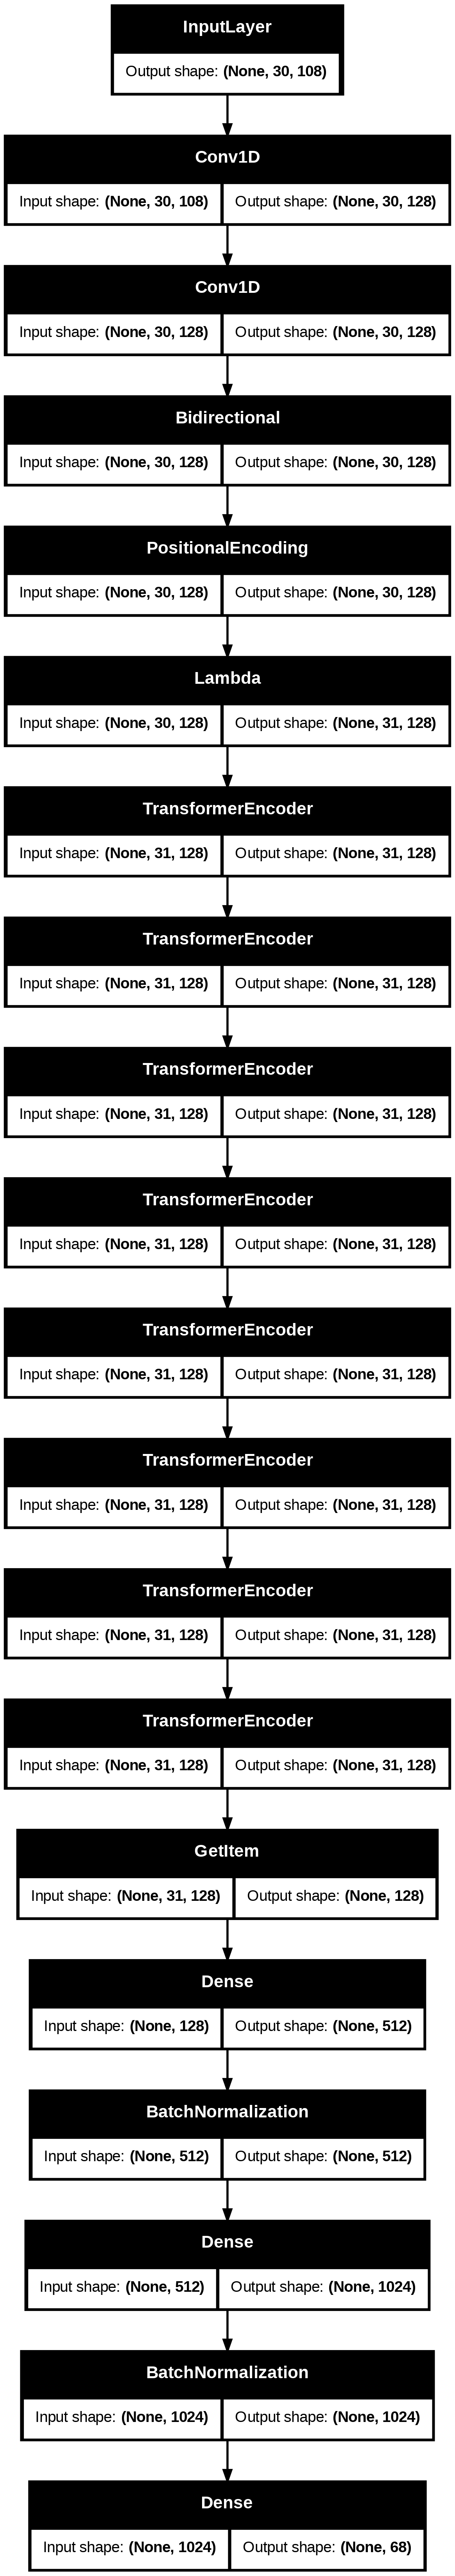

In [ ]:
vsl_model = ViTSignLanguageModel(seq_len=SEQ_LEN, feature_dim=108, num_classes=NUM_WORD)
vsl_model.build((SEQ_LEN, 108))
vsl_model.summary()
vsl_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
keras.utils.plot_model(vsl_model.build_graph((SEQ_LEN, 108)), show_shapes=True)

In [ ]:
early_stopping_calback=keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, mode='min', restore_best_weights=True)

train_history = vsl_model.fit(x=feature_train,y=label_train,epochs=50,batch_size=16,
                              shuffle=True,validation_split=0.1,
                              class_weight = class_weight,
                              callbacks=[early_stopping_calback])

Epoch 1/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 97s 90ms/step - accuracy: 0.1245 - loss: 3.6662 - val_accuracy: 0.9701 - val_loss: 0.1958
Epoch 2/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - accuracy: 0.9779 - loss: 0.1312 - val_accuracy: 0.9785 - val_loss: 0.0695
Epoch 3/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9878 - loss: 0.0552 - val_accuracy: 0.9916 - val_loss: 0.0405
Epoch 4/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.9914 - loss: 0.0334 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 5/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 7.4007e-04
Epoch 6/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 1.0000 - loss: 6.5810e-04 - val_accuracy: 1.0000 - val_loss: 5.0421e-04
Epoch 7/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 1.0000 - loss: 4.5693e-04 - val_accuracy: 1.0000 - val_loss: 3.5856e-04
Epoch 8/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 1.00

[55 19  6  6 45  1 49 22 65 15 48]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 3.2512e-08


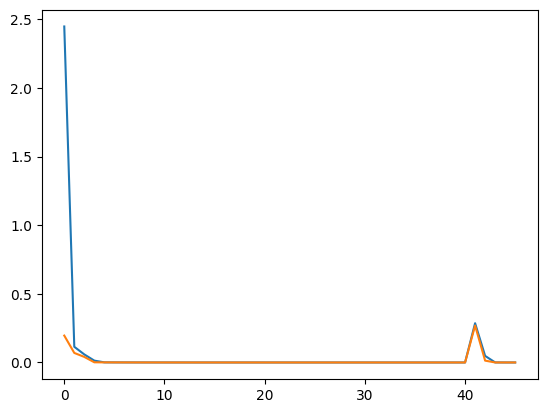

In [ ]:
#evaluate model on test
print(np.argmax(label_test,axis = 1))
vsl_model.evaluate(x=feature_test,y=label_test)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])

In [ ]:
date_fmt = '%d_%m_%Y_%H_%M_%s'
date = dt.datetime.now()
formatted_date = date.strftime(date_fmt)

model_file_name = f'model_{formatted_date}.keras'
vsl_model.save(filepath=f'Model para/{model_file_name}')

In [ ]:
test = keras.models.load_model(f'Model para/{model_file_name}')

In [ ]:
vsl_model.evaluate(x=feature_train,y=label_train)


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9952 - loss: 0.0110


[0.010356234386563301, 0.9961950778961182]